# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
* Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Данные взяты с сайта ChaLearn Looking at People

План работы:
* Провести исследовательский анализ набора фотографий. Сделать выводы о том, как результаты исследования повлияют на обучение модели.
* Подготовить данные к обучению.
* Обучить нейронную сеть и рассчитать её качество.


## Исследовательский анализ данных

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns


In [8]:
sns.set_style('darkgrid')

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)


Found 7591 validated image filenames.


In [3]:
labels.shape


(7591, 2)

In [4]:
labels.describe()


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
labels.info()

In [ ]:
labels.head()

Text(0.5, 1.0, 'Гистограмма')

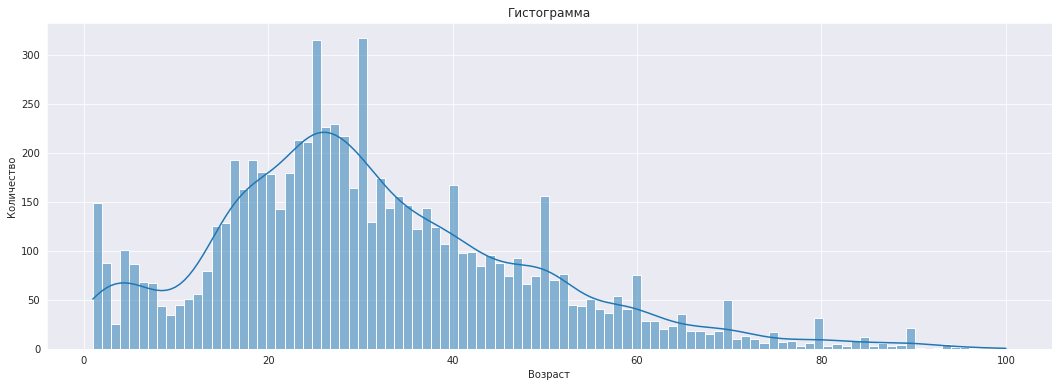

In [23]:
fig, axs = plt.subplots(figsize=(18, 6))
sns.histplot(data=labels, x='real_age', ax=axs, bins=100, kde=True)
axs.set_xlabel('Возраст')
axs.set_ylabel('Количество')
axs.set_title('Гистограмма')

Пики приходятся на 25, 30 лет

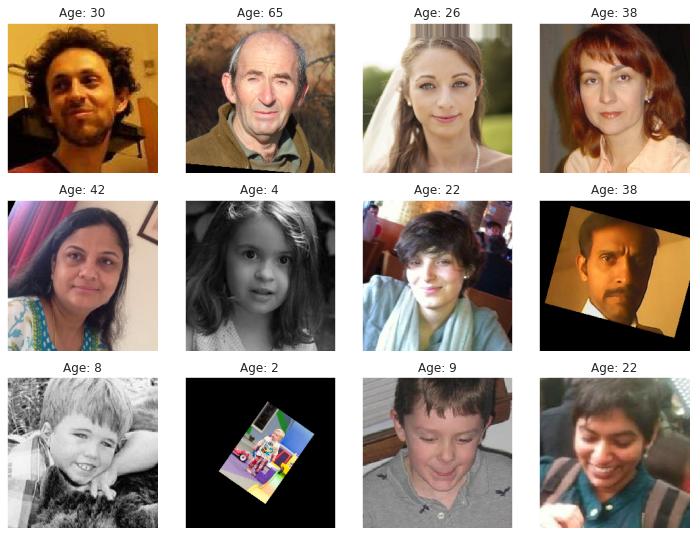

In [21]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10, 10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Age: {target[i]}")  
    plt.tight_layout()
plt.show()

### Промежуточный вывод
Датасет содержит 7591 фотографий покупателей разных ворастных групп, присутсвуют фотографии в ч/б формате, есть фотографии с разными углами ракурсов, больше всего фотографий людей в возростной группе от 20 до 30 лет

## Обучение модели

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50 


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')  
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', 
        seed=42)
    return test_datagen_flow

def create_model(input_shape):
    
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet', 
                    include_top= False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae']) 
    return model
    
    
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2025-08-05 16:48:24.237590: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-05 16:48:24.631769: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 78s - loss: 183.0326 - mae: 10.0450 - val_loss: 343.1084 - val_mae: 13.7042
Epoch 2/10
178/178 - 38s - loss: 101.0734 - mae: 7.6873 - val_loss: 342.8460 - val_mae: 13.6969
Epoch 3/10
178/178 - 38s - loss: 67.0072 - mae: 6.2290 - val_loss: 347.9930 - val_mae: 13.8055
Epoch 4/10
178/178 - 38s - loss: 43.6158 - mae: 5.0749 - val_loss: 163.0770 - val_mae: 9.9155
Epoch 5/10
178/178 - 38s - loss: 29.7320 - mae: 4.2129 - val_loss: 108.7496 - val_mae: 7.7018
Epoch 6/10
178/178 - 38s - loss: 22.4007 - mae: 3.6563 - val_loss: 81.6747 - val_mae: 6.8287
Epoch 7/10
178/178 - 38s - loss: 19.0658 - mae: 3.3705 - val_loss: 74.9024 - val_mae: 6.4437
Epoch 8/10
178/178 - 38s - loss: 13.9460 - mae: 2.8681 - val_loss: 77.9265 - val_mae: 6.6877
Epoch 9/10
178/178 - 38s - loss: 10.6866 - mae: 2.5052 - val_loss: 74.4296 - val_mae: 6.5342
Epoch 10/10
178/178 - 38s - loss: 8.1548 - mae: 2.1935 - val_loss: 80.2306 - val_mae: 6.6503

60/60 - 10s - loss: 80.2306 - mae: 6.6503

```

## Анализ обученной модели

В проекте была успешно обучена модель для предсказания возраста человека по фотографии на основе архитектуры `ResNet50`. 

Использование предобученных весов и аугментации данных позволило достичь целевого показателя MAE < 8.
Получили результат на тестовой выборке 6.6 на 10 эпохе, что удовлетворяет поставленным требованиям. 

То есть, модель делает погрешность предсказанного возраста ± 6.6 лет. Из-за чего с задачей *контролировать добросовестность кассиров при продаже алкоголя* модель будет выполнять с ошибками. Для этой задачи нужно выполнить бинарную классификацию совершеннолетия покупателя 

